# pre-processing gene expression data

Let's load the PBMC dataset from 10x Genomics that we previously used (read and then saved) in the [read and save](shared/bryan/abx/training/single_cell/01_read-and-save-data.ipynb) notebook. First we need to import `scab`, and then we can load from the saved `.h5ad` file:

In [3]:
import scab

In [4]:
adata = scab.read("./data/10k-PBMCs_from-10x/adatas/read-and-save.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 9391 × 36601
    obs: 'bcr', 'bcr_pairing', 'is_bcr_pair', 'tcr', 'tcr_pairing', 'is_tcr_pair'
    var: 'gene_ids', 'feature_types'

<br>  

The first thing we need to do is some filtering. The parameters we use to filter can differ between datasets, so we'll make some plots to help us empirically determine where to best set our filtering thresholds. The thresholds we care most about are **mitochondrial count** and **gene count**:
* `microchondrial count`: This is the frequency of reads that map to mitochondrial DNA, as a percent of the total number of reads per cell. Our default threshold is `10`, but this can be adjusted on a per-dataset basis.
* `gene count`: The number of unique genes identified per cell. Although our default is reasonable (`2500`), this can vary substantially based on input cell quality and sequencing depth.

Feel free to play with the default values, but the below modifications seem pretty reasonable for this dataset:

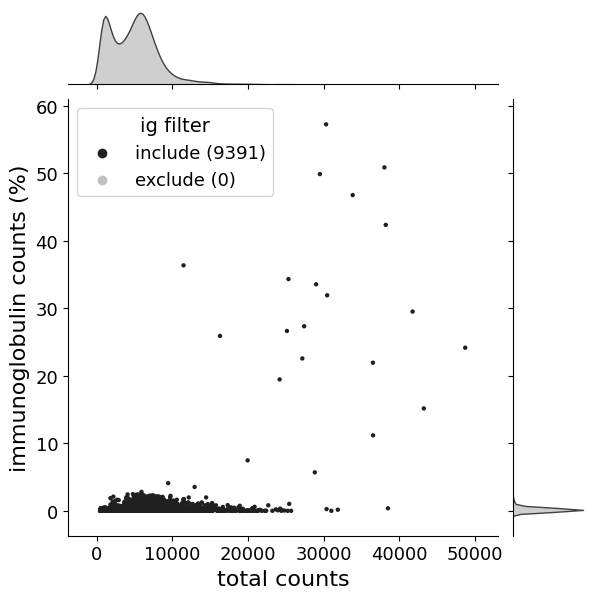

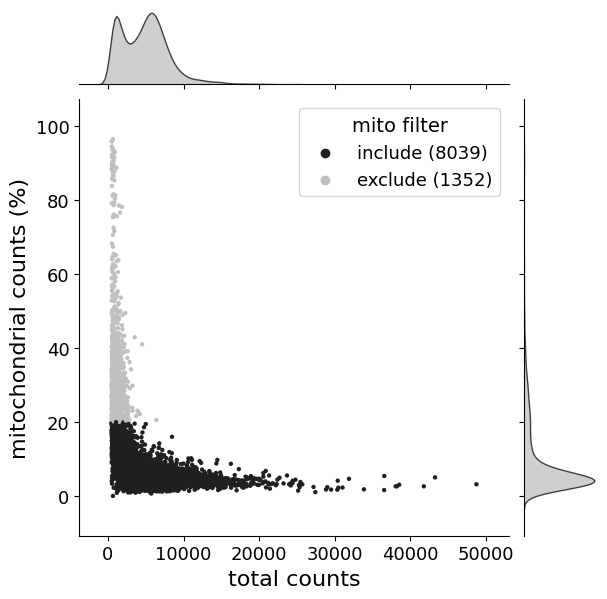

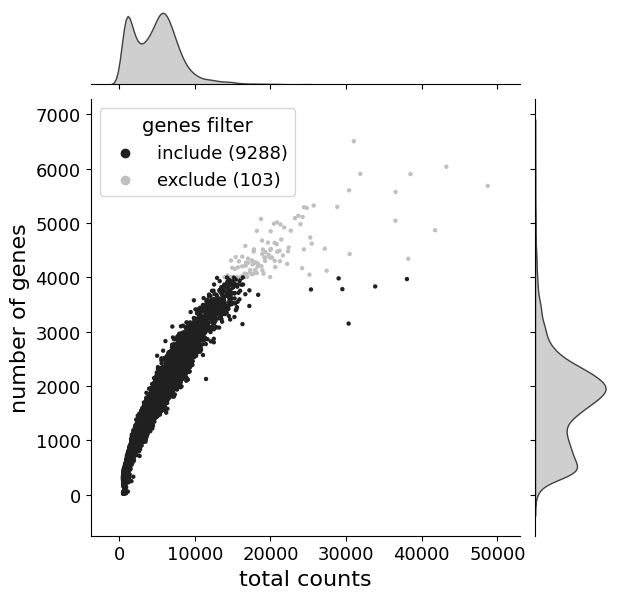

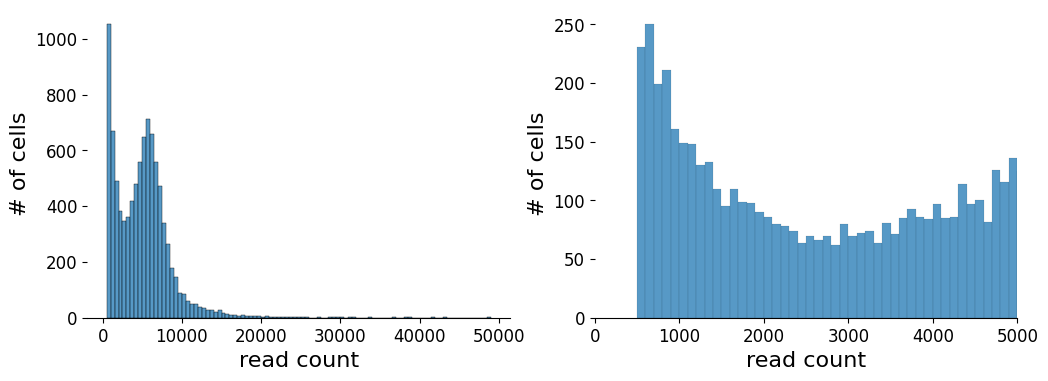

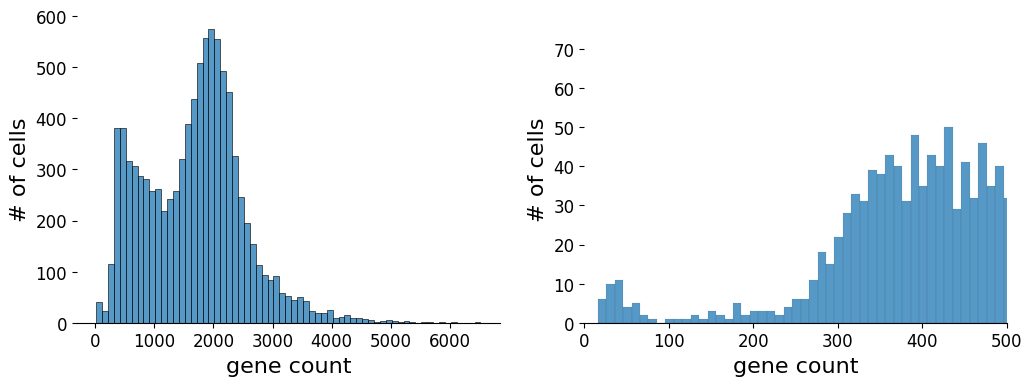

In [9]:
scab.pl.qc_metrics(
    adata, 
    ngenes_cutoff=4000,
    mito_cutoff=20,
)

<br>  
  
Once we've decided on our thresholds, we can filter and normalize our dataset using the `filter_and_normalize()` function.

We normalize gene counts using [LNP1](https://en.wikipedia.org/wiki/Natural_logarithm#lnp1), which computes the natural log of `(counts + 1)`. The "plus 1" part is important -- most of our cells have `0` counts for some number of genes, and `log(0)` is undefined. Adding `1` to all gene counts makes only a very small difference to each count but allows us to easily compute the log-normalized value. Plus, `log(1) = 0`, which means that genes with `0` raw counts will still be `0` following LNP1 normalization.

Notice that the **gene count** threshold is passed to `n_genes_by_counts` (which matches the name used by `Scanpy`), and the **mitochondrial count** threshold is passed to `percent_mito`:

In [10]:
adata = scab.pp.filter_and_normalize(
    adata,
    n_genes_by_counts=4000,
    percent_mito=20,
)

filtering cells with fewer than 200 genes...
filtering genes found in fewer than 9 cells...
QC...
filtering based on percent Ig and percent mito...
normalizing...
scaling...


<br>  

If you were paying close attention, you noticed that we saved our new (filtered) dataset to the same variable name (`adata`) as the unfiltered data. This means that the unfiltered data was overwritten, and `adata` is now just our filtered data. If you want to keep the unfiltered dataset around for some reason, you can save to a new variable with something like `filtered_adata = scab.pp.filter_and_normalize(...)`.  
  
Let's take a look at our new `adata` object:

In [12]:
adata

AnnData object with n_obs × n_vars = 7935 × 17080
    obs: 'bcr', 'bcr_pairing', 'is_bcr_pair', 'tcr', 'tcr_pairing', 'is_tcr_pair', 'n_genes_by_counts', 'total_counts', 'total_counts_ig', 'pct_counts_ig', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'ig', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

<br>  

First of all, `obs` and `var` now have a whole lot more information. All of that was added by our filtering and normalization tools. Don't worry about any of that now, we're not going to use it just yet. The second thing is that we now only have `7,935` cells (compared to `9,391` in the unfiltered data). Our filtering process resulted in the removal of `1,456` cells.
  
Now let's calculate a Uniform Manifold Approimation and Projection ([UMAP](https://www.nature.com/articles/nbt.4314)) embedding for our data, which we'll use to plot the gene expression data. UMAP has several steps, including principal components analysis and identifying nearest neighbors, but `scab` integrates all of that into a single `umap()` function:

In [13]:
adata = scab.tl.umap(adata)


UMAP EMBEDDING
--------------
  - computing PCA
  - calculating neighbors
  - leiden clustering
  - paga
  - umap


<br>  
  
Just like `filter_and_normalize()`, `umap()` has added a fair bit of information to our `adata` object:

In [20]:
adata

AnnData object with n_obs × n_vars = 7935 × 17080
    obs: 'bcr', 'bcr_pairing', 'is_bcr_pair', 'tcr', 'tcr_pairing', 'is_tcr_pair', 'n_genes_by_counts', 'total_counts', 'total_counts_ig', 'pct_counts_ig', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'ig', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<br>  
  
Now that we've compute the UMAP embedding, we can make a UMAP plot of our transcriptomics data. As part of the UMAP calculation with `umap()`, we clustered the cells using the [Lenden](https://www.nature.com/articles/s41598-019-41695-z) algorithm. The cluster assignments are found in `obs`, in the `"leiden"` column. The following will plot all cells according to their UMAP coordinates, and color them according to their `leiden` cluster:

<AxesSubplot: >

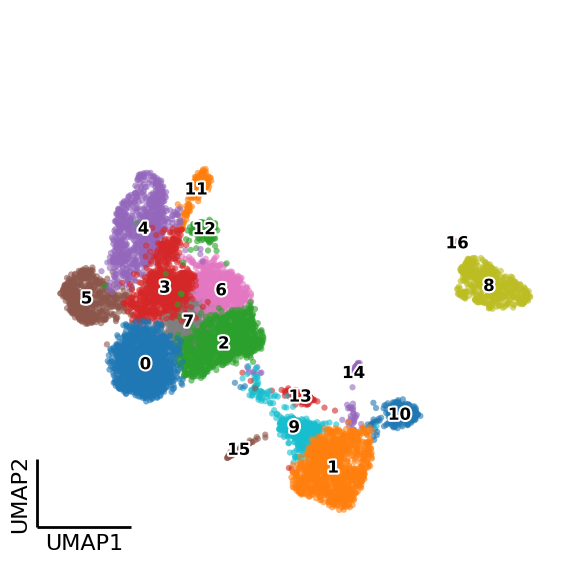

In [21]:
scab.pl.umap(
    adata,
    "leiden",
    legend_on_data=True,
)

<br>  
  
Awesome, but what does that mean? Which cells are in which clusters? At least right now, there aren't any great tools for automated assignemnt of cell types. We kinda just have to do that on our own. Let's start with a gene that we know is found on all B cells: `CD19`. We can color our UMAP plot according to `CD19` expression by replacing the `"leiden"` argument from the previous plot with `"CD19"`:

<AxesSubplot: >

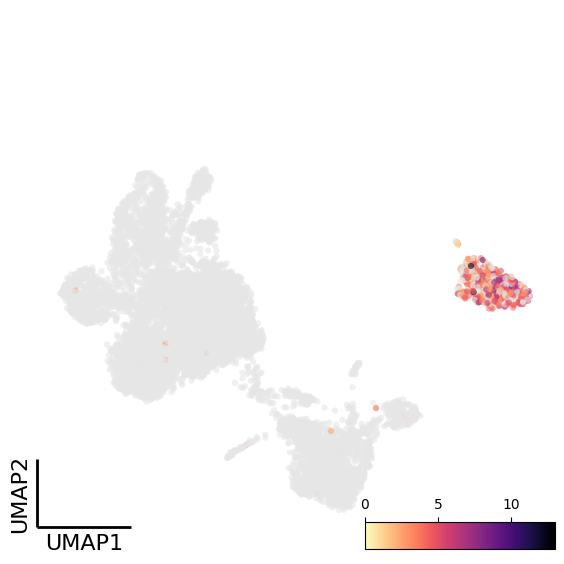

In [34]:
scab.pl.umap(
    adata,
    "CD19",
    hue_min=0,
)

<br>  
  
It looks like clusters `8` and `16` are our B cells. Let's make a new `AnnData` object that contains just B cells, which we'll use in later notebooks, and save it. To do this, we can select only cells that belong to the B cell clusters. One thing to notice is that the `leiden` cluster names are saved as `string`s, even though they're numbers:

In [35]:
bcells = adata[adata.obs.leiden.isin(["6", "18"])]

In [37]:
scab.write(bcells, "./data/10k-PBMCs_from-10x/adatas/bcells.h5ad")